<a href="https://colab.research.google.com/github/Mel-iza/Getting-Started-with-Ray-Tune/blob/main/ray_tune_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h2>Getting Started with Ray Tune</h2>
This tutorial will walk you through the process of setting up a Tune experiment. To get started, we take a PyTorch model and show you how to leverage Ray Tune to optimize the hyperparameters of this model. Specifically, we’ll leverage early stopping and Bayesian Optimization via HyperOpt to do so.

[Reference](https://docs.ray.io/en/latest/tune/getting-started.html#tune-tutorial)

In [1]:
!pip install "ray[tune]" torch torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.6/58.6 MB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 KB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.5/468.5 KB 15.8 MB/s eta 0:00:00


**Setting Up a Pytorch Model to Tune**

In [2]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F

from ray import air, tune
from ray.tune.schedulers import ASHAScheduler

Then, let’s define a simple PyTorch model that we’ll be training. If you’re not familiar with PyTorch, the simplest way to define a model is to implement a nn.Module. This requires you to set up your model with __init__ and then implement a forward pass. In this example we’re using a small convolutional neural network consisting of one 2D convolutional layer, a fully connected layer, and a softmax function.

In [3]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # In this example, we don't change the model architecture
        # due to simplicity.
        self.conv1 = nn.Conv2d(1, 3, kernel_size=3)
        self.fc = nn.Linear(192, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 3))
        x = x.view(-1, 192)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

In [4]:

# Change these values if you want the training to run quicker or slower.
EPOCH_SIZE = 512
TEST_SIZE = 256

def train(model, optimizer, train_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # We set this just for the example to run quickly.
        if batch_idx * len(data) > EPOCH_SIZE:
            return
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()


def test(model, data_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(data_loader):
            # We set this just for the example to run quickly.
            if batch_idx * len(data) > TEST_SIZE:
                break
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    return correct / total

**Setting up a Tuner for a Training Run with Tune**

In [5]:
def train_mnist(config):
    # Data Setup
    mnist_transforms = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.1307, ), (0.3081, ))])

    train_loader = DataLoader(
        datasets.MNIST("~/data", train=True, download=True, transform=mnist_transforms),
        batch_size=64,
        shuffle=True)
    test_loader = DataLoader(
        datasets.MNIST("~/data", train=False, transform=mnist_transforms),
        batch_size=64,
        shuffle=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = ConvNet()
    model.to(device)

    optimizer = optim.SGD(
        model.parameters(), lr=config["lr"], momentum=config["momentum"])
    for i in range(10):
        train(model, optimizer, train_loader)
        acc = test(model, test_loader)

        # Send the current training result back to Tune
        tune.report(mean_accuracy=acc)

        if i % 5 == 0:
            # This saves the model to the trial directory
            torch.save(model.state_dict(), "./model.pth")

In [6]:
search_space = {
    "lr": tune.sample_from(lambda spec: 10 ** (-10 * np.random.rand())),
    "momentum": tune.uniform(0.1, 0.9),
}

# Uncomment this to enable distributed execution
# `ray.init(address="auto")`

# Download the dataset first
datasets.MNIST("~/data", train=True, download=True)

tuner = tune.Tuner(
    train_mnist,
    param_space=search_space,
)
results = tuner.fit()

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /root/data/MNIST/raw/train-images-idx3-ubyte.gz to /root/data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /root/data/MNIST/raw/train-labels-idx1-ubyte.gz to /root/data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /root/data/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /root/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/data/MNIST/raw



2023-03-27 18:02:17,329	INFO worker.py:1553 -- Started a local Ray instance.


Trial name,date,done,episodes_total,experiment_id,experiment_tag,hostname,iterations_since_restore,mean_accuracy,node_ip,pid,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
train_mnist_838e9_00000,2023-03-27_18-02-26,True,,08d26622b85f4036b1169a74eb5ee773,"0_lr=0.0000,momentum=0.4210",9a427e40e973,10,0.065625,172.28.0.12,1435,3.82413,0.460109,3.82413,1679940146,0,,10,838e9_00000,0.00674391


2023-03-27 18:02:26,226	INFO tune.py:798 -- Total run time: 7.65 seconds (7.38 seconds for the tuning loop).


[<Axes: >]

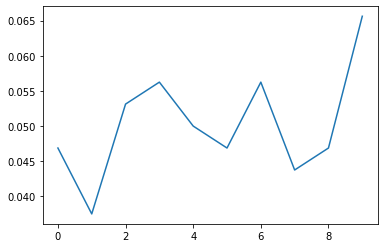

In [7]:
dfs = {result.log_dir: result.metrics_dataframe for result in results}
[d.mean_accuracy.plot() for d in dfs.values()]

**Early Stopping with Adaptive Successive Halving (ASHAScheduler)**

In [8]:
tuner = tune.Tuner(
    train_mnist,
    tune_config=tune.TuneConfig(
        num_samples=20,
        scheduler=ASHAScheduler(metric="mean_accuracy", mode="max"),
    ),
    param_space=search_space,
)
results = tuner.fit()

# Obtain a trial dataframe from all run trials of this `tune.run` call.
dfs = {result.log_dir: result.metrics_dataframe for result in results}

Trial name,date,done,episodes_total,experiment_id,experiment_tag,hostname,iterations_since_restore,mean_accuracy,node_ip,pid,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
train_mnist_c5fb6_00000,2023-03-27_18-04-24,True,,5b60622f794348d5be86fdf845d5ad0d,"0_lr=0.0000,momentum=0.8456",9a427e40e973,10,0.128125,172.28.0.12,1971,10.5603,0.489154,10.5603,1679940264,0,,10,c5fb6_00000,0.00422573
train_mnist_c5fb6_00001,2023-03-27_18-04-19,True,,00836385233f4159b30eb5e3064a5443,,9a427e40e973,1,0.05625,172.28.0.12,2063,1.32553,1.32553,1.32553,1679940259,0,,1,c5fb6_00001,0.00777793
train_mnist_c5fb6_00002,2023-03-27_18-04-20,True,,00836385233f4159b30eb5e3064a5443,,9a427e40e973,1,0.08125,172.28.0.12,2063,1.10322,1.10322,1.10322,1679940260,0,,1,c5fb6_00002,0.00777793
train_mnist_c5fb6_00003,2023-03-27_18-04-27,True,,00836385233f4159b30eb5e3064a5443,"3_lr=0.5543,momentum=0.5636",9a427e40e973,10,0.846875,172.28.0.12,2063,6.6808,0.502638,6.6808,1679940267,0,,10,c5fb6_00003,0.00777793
train_mnist_c5fb6_00004,2023-03-27_18-04-25,True,,5b60622f794348d5be86fdf845d5ad0d,,9a427e40e973,1,0.096875,172.28.0.12,1971,0.629739,0.629739,0.629739,1679940265,0,,1,c5fb6_00004,0.00422573
train_mnist_c5fb6_00005,2023-03-27_18-04-25,True,,5b60622f794348d5be86fdf845d5ad0d,,9a427e40e973,1,0.078125,172.28.0.12,1971,0.640527,0.640527,0.640527,1679940265,0,,1,c5fb6_00005,0.00422573
train_mnist_c5fb6_00006,2023-03-27_18-04-26,True,,5b60622f794348d5be86fdf845d5ad0d,,9a427e40e973,1,0.08125,172.28.0.12,1971,0.629448,0.629448,0.629448,1679940266,0,,1,c5fb6_00006,0.00422573
train_mnist_c5fb6_00007,2023-03-27_18-04-27,True,,5b60622f794348d5be86fdf845d5ad0d,,9a427e40e973,1,0.09375,172.28.0.12,1971,0.625123,0.625123,0.625123,1679940267,0,,1,c5fb6_00007,0.00422573
train_mnist_c5fb6_00008,2023-03-27_18-04-29,True,,5b60622f794348d5be86fdf845d5ad0d,,9a427e40e973,4,0.15625,172.28.0.12,1971,2.22688,0.545495,2.22688,1679940269,0,,4,c5fb6_00008,0.00422573
train_mnist_c5fb6_00009,2023-03-27_18-04-28,True,,00836385233f4159b30eb5e3064a5443,,9a427e40e973,1,0.065625,172.28.0.12,2063,0.606567,0.606567,0.606567,1679940268,0,,1,c5fb6_00009,0.00777793


2023-03-27 18:04:40,869	INFO tune.py:798 -- Total run time: 30.85 seconds (30.76 seconds for the tuning loop).


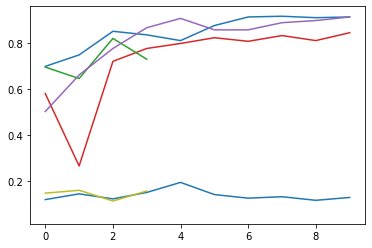

In [9]:
# Plot by epoch
ax = None  # This plots everything on the same plot
for d in dfs.values():
    ax = d.mean_accuracy.plot(ax=ax, legend=False)

**Using Search Algorithms in Tune**

In [10]:
from hyperopt import hp
from ray.tune.search.hyperopt import HyperOptSearch

space = {
    "lr": hp.loguniform("lr", -10, -1),
    "momentum": hp.uniform("momentum", 0.1, 0.9),
}

hyperopt_search = HyperOptSearch(space, metric="mean_accuracy", mode="max")

tuner = tune.Tuner(
    train_mnist,
    tune_config=tune.TuneConfig(
        num_samples=10,
        search_alg=hyperopt_search,
    ),
)
results = tuner.fit()

# To enable GPUs, use this instead:
# analysis = tune.run(
#     train_mnist, config=search_space, resources_per_trial={'gpu': 1})


Trial name,date,done,episodes_total,experiment_id,experiment_tag,hostname,iterations_since_restore,mean_accuracy,node_ip,pid,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
train_mnist_167907e7,2023-03-27_18-06-13,True,,3cabc4dd929f40fab1b61d17724c55c8,"8_lr=0.0327,momentum=0.1287",9a427e40e973,10,0.8625,172.28.0.12,2685,6.85421,0.887567,6.85421,1679940373,0,,10,167907e7,0.00567818
train_mnist_1a46cfbf,2023-03-27_18-06-18,True,,6ab68467b9fb4e0d8657f8edecfd3ff9,"9_lr=0.0001,momentum=0.7156",9a427e40e973,10,0.059375,172.28.0.12,2634,7.75517,0.520234,7.75517,1679940378,0,,10,1a46cfbf,0.00426841
train_mnist_24155cdd,2023-03-27_18-06-10,True,,6ab68467b9fb4e0d8657f8edecfd3ff9,"7_lr=0.0071,momentum=0.3726",9a427e40e973,10,0.75625,172.28.0.12,2634,8.42472,0.520979,8.42472,1679940370,0,,10,24155cdd,0.00426841
train_mnist_460915a7,2023-03-27_18-05-57,True,,6ab68467b9fb4e0d8657f8edecfd3ff9,"3_lr=0.0006,momentum=0.3579",9a427e40e973,10,0.115625,172.28.0.12,2634,6.088,0.506615,6.088,1679940357,0,,10,460915a7,0.00426841
train_mnist_77566628,2023-03-27_18-06-06,True,,3cabc4dd929f40fab1b61d17724c55c8,"6_lr=0.0001,momentum=0.3246",9a427e40e973,10,0.121875,172.28.0.12,2685,7.38958,1.05184,7.38958,1679940366,0,,10,77566628,0.00567818
train_mnist_803d8b44,2023-03-27_18-05-53,True,,3cabc4dd929f40fab1b61d17724c55c8,"2_lr=0.0005,momentum=0.5983",9a427e40e973,10,0.171875,172.28.0.12,2685,8.41807,0.523894,8.41807,1679940353,0,,10,803d8b44,0.00567818
train_mnist_837480c1,2023-03-27_18-05-59,True,,3cabc4dd929f40fab1b61d17724c55c8,"4_lr=0.0003,momentum=0.4649",9a427e40e973,10,0.059375,172.28.0.12,2685,5.40555,0.517209,5.40555,1679940359,0,,10,837480c1,0.00567818
train_mnist_ae9aa6a7,2023-03-27_18-06-20,True,,3cabc4dd929f40fab1b61d17724c55c8,"10_lr=0.0009,momentum=0.8879",9a427e40e973,10,0.675,172.28.0.12,2685,7.02468,0.470002,7.02468,1679940380,0,,10,ae9aa6a7,0.00567818
train_mnist_db0d6550,2023-03-27_18-06-02,True,,6ab68467b9fb4e0d8657f8edecfd3ff9,"5_lr=0.0137,momentum=0.1605",9a427e40e973,10,0.825,172.28.0.12,2634,5.35438,0.525817,5.35438,1679940362,0,,10,db0d6550,0.00426841
train_mnist_e58ef445,2023-03-27_18-05-50,True,,6ab68467b9fb4e0d8657f8edecfd3ff9,"1_lr=0.0028,momentum=0.4239",9a427e40e973,10,0.64375,172.28.0.12,2634,9.71593,0.91399,9.71593,1679940350,0,,10,e58ef445,0.00426841


2023-03-27 18:06:20,940	INFO tune.py:798 -- Total run time: 44.64 seconds (44.57 seconds for the tuning loop).


**Evaluating Your Model after Tuning**

In [11]:
import os

logdir = results.get_best_result("mean_accuracy", mode="max").log_dir
state_dict = torch.load(os.path.join(logdir, "model.pth"))

model = ConvNet()
model.load_state_dict(state_dict)

<All keys matched successfully>